In [91]:
import os
import numpy as np
import zarr
import qim3d
import skimage
import matplotlib.pyplot as plt
from skimage import measure
from scipy import ndimage
from skimage.filters import threshold_otsu
from utils.utils_plot import viz_slices
from utils.utils_preprocess import plot_histogram
from skimage.segmentation import relabel_sequential

from scipy import ndimage

In [2]:
print(os.getcwd())
#!pip list

/work3/s173944/Python/projects/VoxelReg


In [3]:

bone_path = os.path.join("/work2/aulho", "bone_2_ome_super.zarr")

z = zarr.open(bone_path, mode='r')
print(z.tree())


/
└── HR
    ├── 0 (2584, 10240, 10240) float16
    ├── 1 (1292, 5120, 5120) float16
    └── 2 (646, 2560, 2560) float16

(500, 560, 560)
0.2007
0.8984


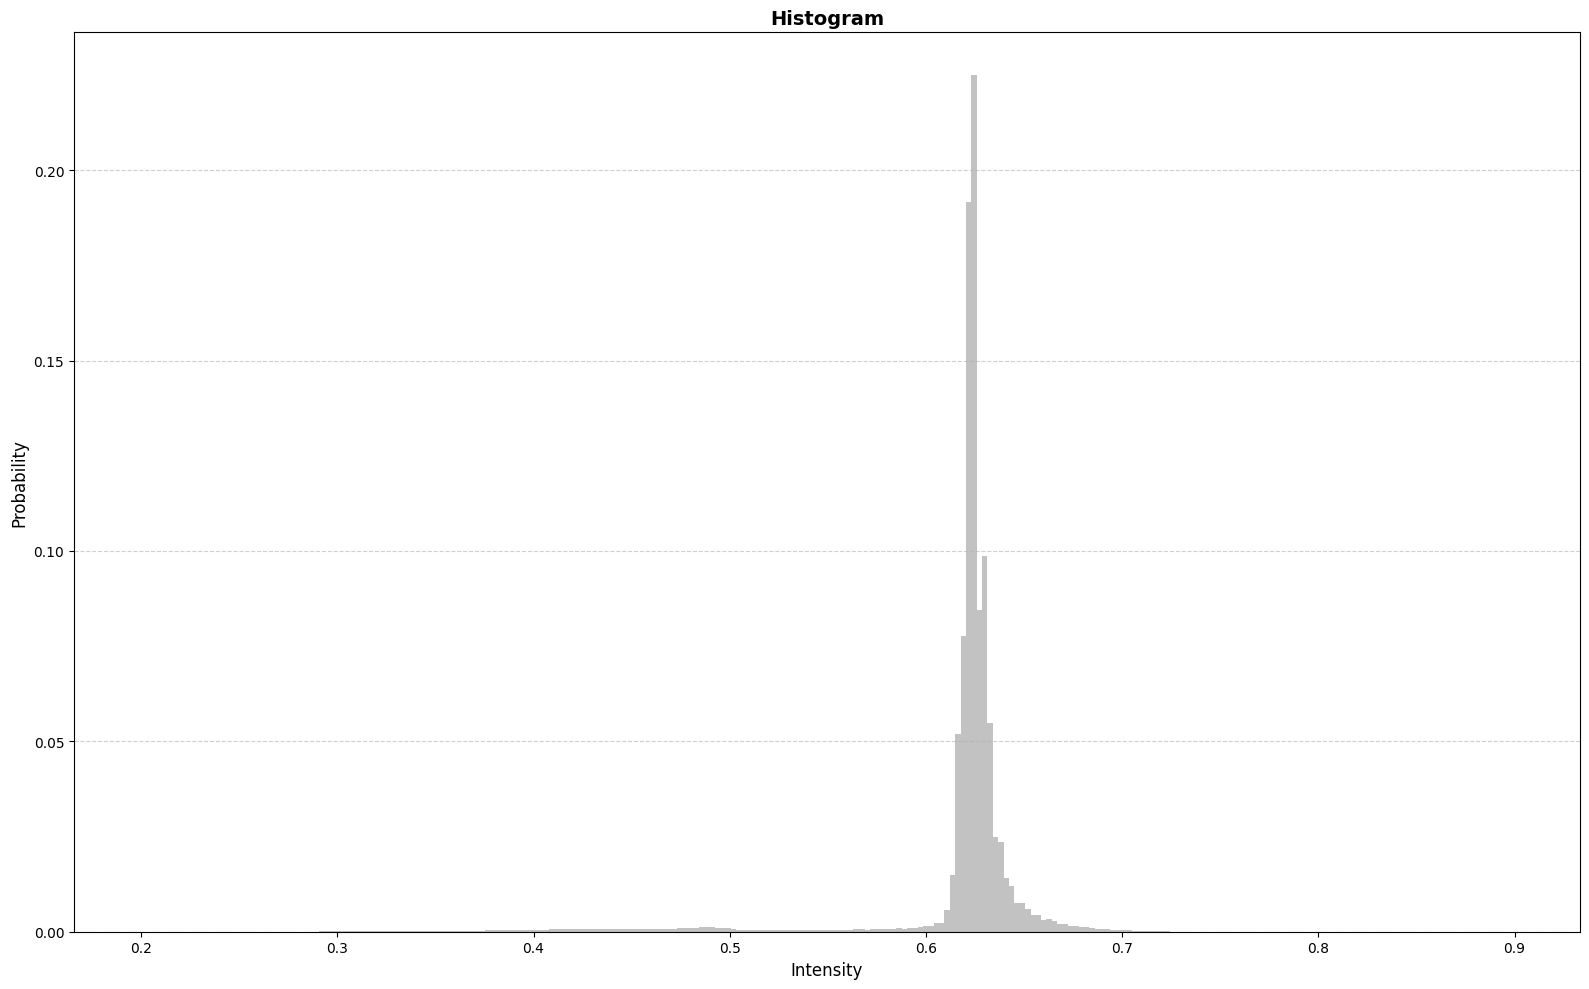

In [13]:

sample = z["HR/2"][100:600, 1000:-1000, 1000:-1000]
print(sample.shape)

print(sample.min())
print(sample.max())

_ = plot_histogram(sample, save_fig=False)


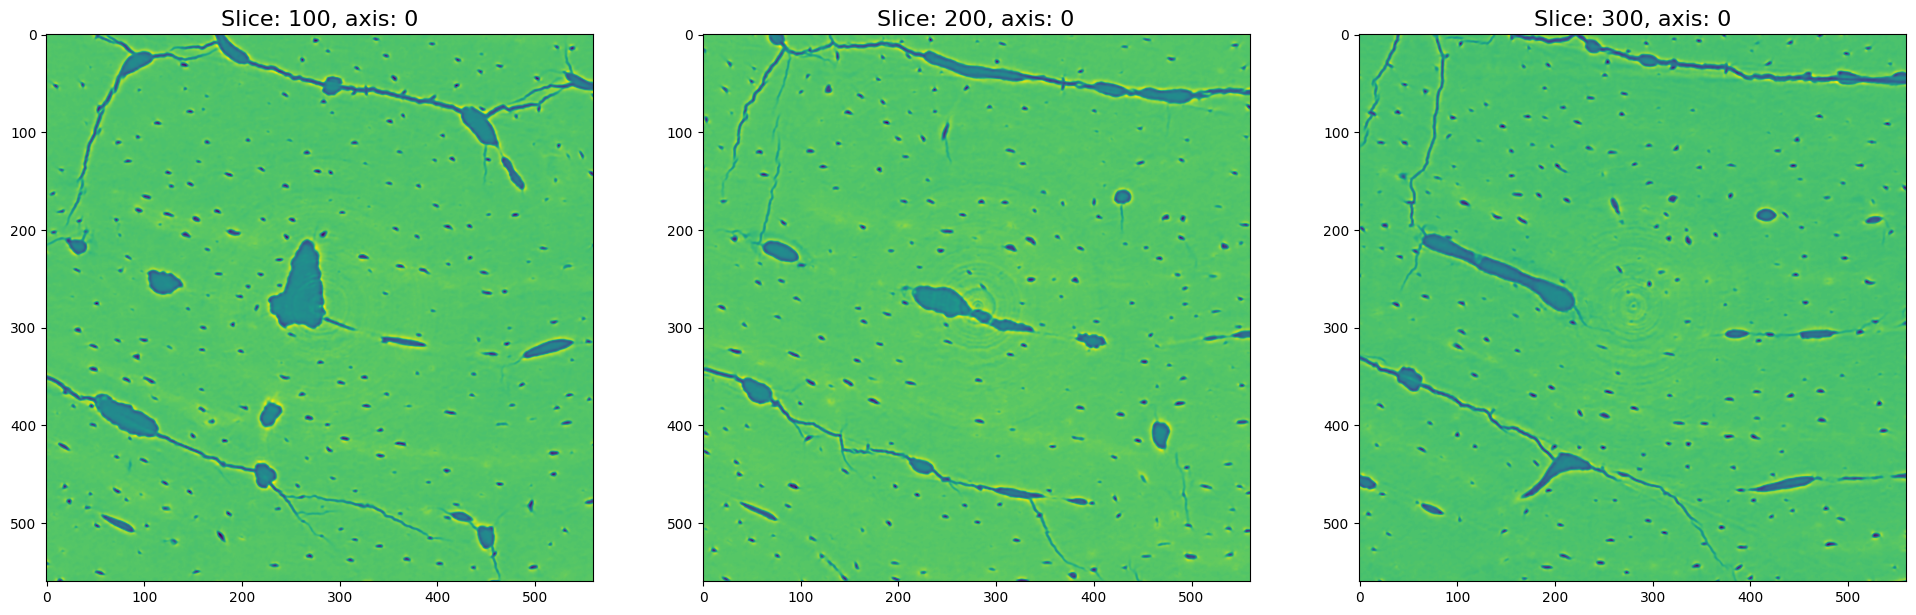

In [7]:

viz_slices(sample, [100, 200, 300], savefig=False)


otsu: 0.5347


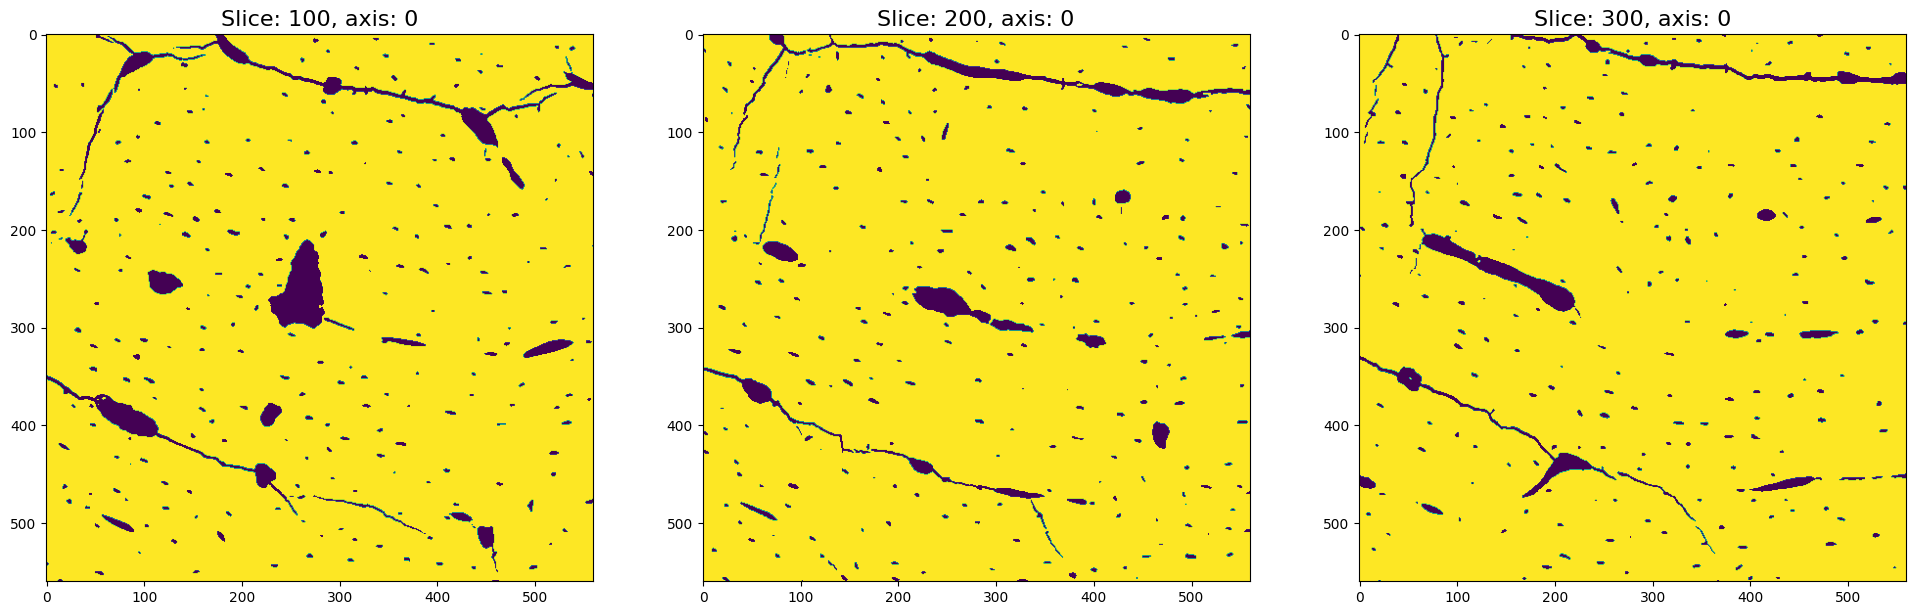

In [19]:
thresh = threshold_otsu(sample)
print("otsu:", thresh)
viz_slices(sample > thresh, [100, 200, 300], savefig=False)


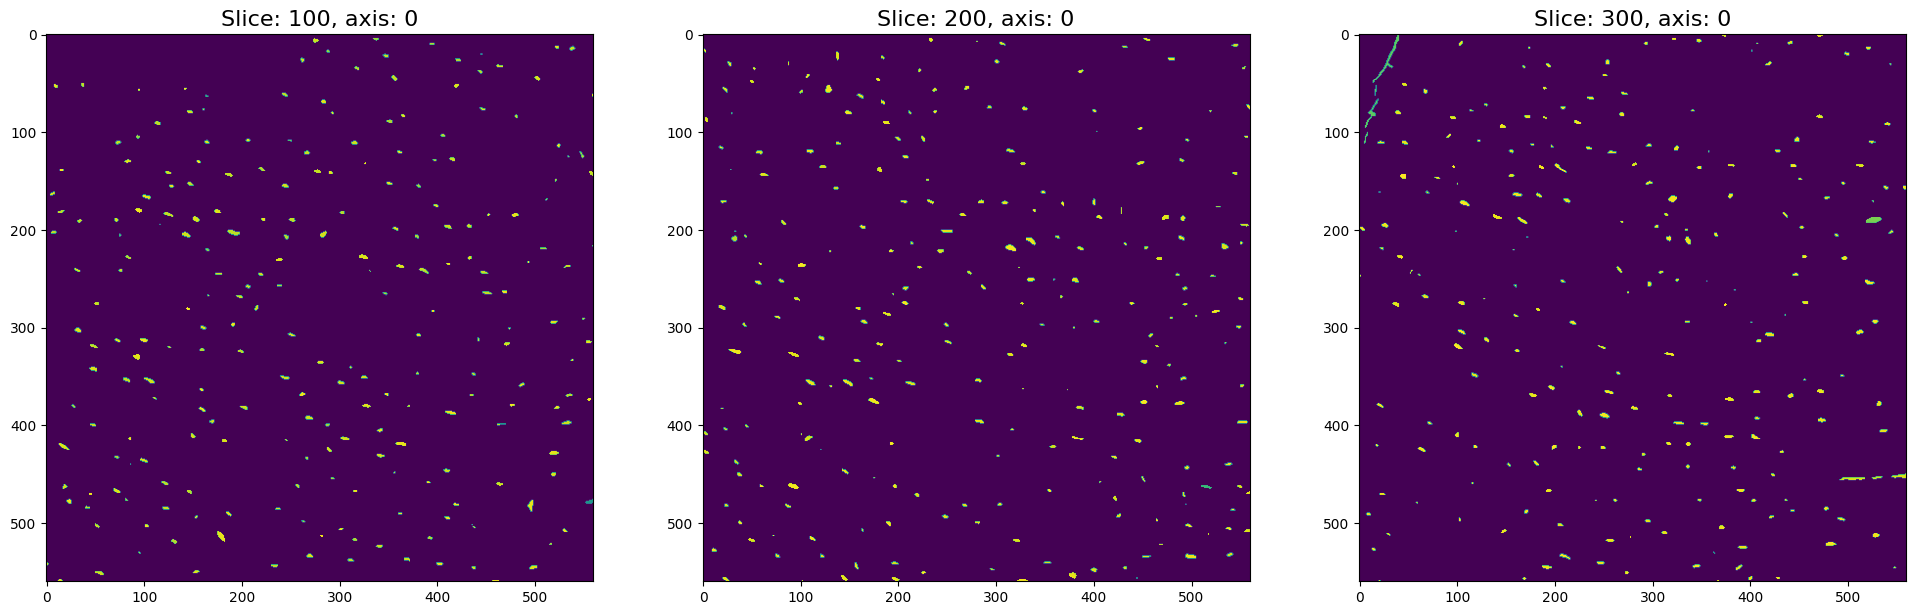

In [53]:
bone_mask = (sample > thresh)
void_mask = ~bone_mask

# Label 3D connected components (26-connectivity by default)
labeled_voids, num_features = ndimage.label(void_mask)

In [ ]:
viz_slices(labeled_voids, [100, 200, 300], savefig=False)

In [93]:
print(num_features)

# Get region properties
props = measure.regionprops(labeled_voids)
len(props)

#print([p.label for p in props[:20]])
#print([p.area for p in props[:20]])

9728


9728

In [94]:
# Loop over components and keep only lacunae in the right size range
voxel_size = 0.275 * 4  # micron, for example
min_vol = 200 / (voxel_size**3)    # convert µm to voxels
max_vol = 1000 / (voxel_size**3)   # canals are larger

labels_to_keep = [p.label for p in props if min_vol <= p.area <= max_vol]
mask = np.isin(labeled_voids, labels_to_keep)

lacunae_mask, _, _ = relabel_sequential(labeled_voids * mask)

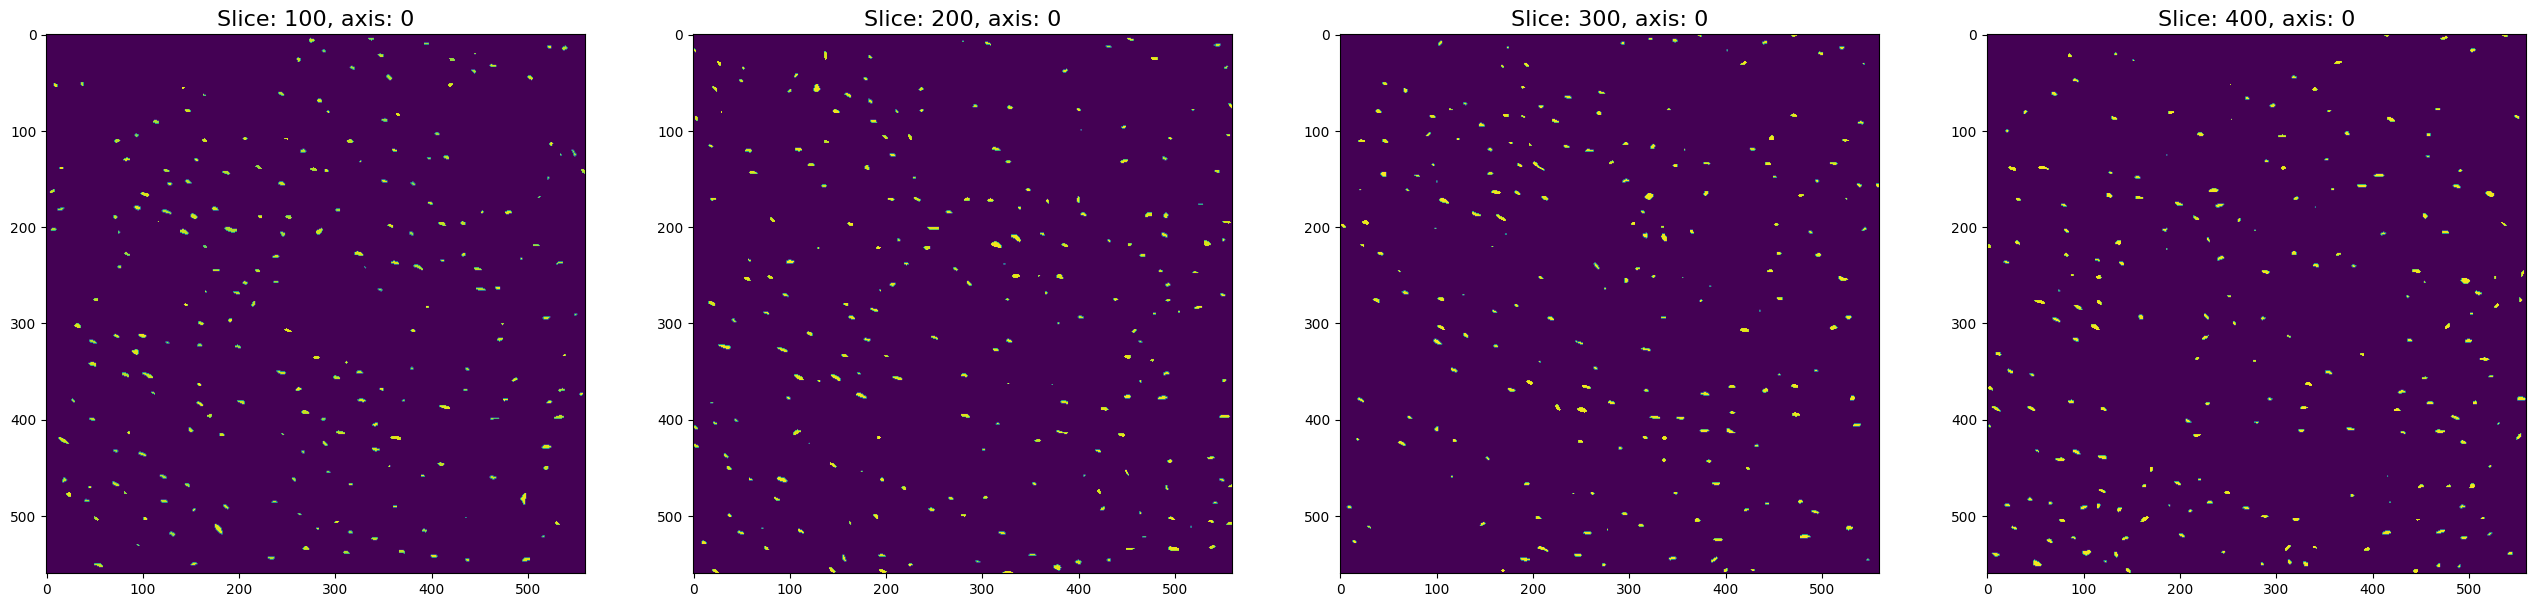

In [95]:
viz_slices(lacunae_mask, [100, 200, 300, 400], savefig=False)



In [111]:
import numpy as np
from skimage import measure
from scipy import ndimage

# --- Fast voxel-based surface area ---
def compute_surface_area_voxel(labeled, labels=None, voxel_size=1.0):
    """
    Approximate surface area for each label using voxel faces.
    Much faster than marching cubes.
    
    Parameters
    ----------
    labeled : 3D ndarray
        Labeled image of lacunae.
    labels : list or ndarray, optional
        Specific labels to compute (default: all >0).
    voxel_size : float
        Physical size of one voxel edge.
    
    Returns
    -------
    dict {label: surface_area}
    """
    # 6-neighborhood kernel
    kernel = np.zeros((3,3,3), dtype=int)
    kernel[1,1,0] = kernel[1,1,2] = 1
    kernel[1,0,1] = kernel[1,2,1] = 1
    kernel[0,1,1] = kernel[2,1,1] = 1

    surface_areas = {}

    if labels is None:
        labels = np.unique(labeled)
        labels = labels[labels > 0]  # skip background

    for i, label in enumerate(labels):
        mask = (labeled == label).astype(np.uint8)

        if mask.sum() == 0:
            surface_areas[label] = 0.0
            continue

        neighbors = ndimage.convolve(mask, kernel, mode="constant", cval=0)
        boundary_faces = (mask * (6 - neighbors)).sum()

        sa = float(boundary_faces) * (voxel_size**2)
        surface_areas[label] = sa

    return surface_areas


# --- Volume + surface area for all lacunae ---
def compute_region_metrics(labeled_lacunae, voxel_size=1.0):
    props = measure.regionprops(labeled_lacunae)
    labels = [p.label for p in props]
    volumes = [p.area * (voxel_size**3) for p in props]

    sa_dict = compute_surface_area_voxel(labeled_lacunae, labels, voxel_size)
    surface_areas = [sa_dict.get(lbl, 0.0) for lbl in labels]

    return {
        "labels": np.array(labels),
        "volumes": np.array(volumes),
        "surface_areas": np.array(surface_areas)
    }


# --- Shape tensor for stretch & oblateness ---
def compute_shape_tensor(coords):
    coords = np.array(coords)
    center = coords.mean(axis=0)
    displacements = coords - center
    S = np.dot(displacements.T, displacements) / len(coords)
    return S

def compute_stretch_oblateness(S):
    eigvals, eigvecs = np.linalg.eigh(S)
    eigvals = np.sort(eigvals)  # λS,1 <= λS,2 <= λS,3
    lam1, lam2, lam3 = eigvals

    stretch = (lam3 - lam1) / lam3 if lam3 > 0 else 0
    oblateness = np.nan
    if lam3 > lam1:  # avoid division by zero
        oblateness = 2 * (lam2 - lam1) / (lam3 - lam1) - 1

    return stretch, oblateness, eigvals, eigvecs


# --- Closed bone volume ---
def compute_closed_bone_volume(bone_mask, structure=None):
    closed = ndimage.binary_closing(bone_mask, structure=structure)
    return closed.sum()


# --- Main pipeline ---
def analyze_bone(bone_mask, lacunae_mask, voxel_size=1.0):
    """
    Analyze bone structure: volume, surface area, stretch, oblateness,
    closed bone volume, and lacunar density.
    
    Parameters
    ----------
    bone_mask : 3D ndarray
        Binary mask of bone (1 = bone, 0 = void).
    lacunae_mask : 3D ndarray
        Labeled lacunae (0 = background, >0 = unique lacuna labels).
    voxel_size : float
        Physical size of one voxel edge (e.g., microns).
    
    Returns
    -------
    results : dict
        Dictionary with per-lacuna metrics and global metrics.
    """
    # Volume + surface area
    region_metrics = compute_region_metrics(lacunae_mask, voxel_size)

    # Stretch & oblateness
    stretches, oblatenesses = [], []
    for label in region_metrics["labels"]:
        coords = np.argwhere(lacunae_mask == label)
        S = compute_shape_tensor(coords * voxel_size)
        stretch, oblateness, _, _ = compute_stretch_oblateness(S)
        stretches.append(stretch)
        oblatenesses.append(oblateness)

    # Closed bone volume
    closed_volume = compute_closed_bone_volume(bone_mask)

    # Number density
    num_lacunae = len(region_metrics["labels"])
    density = num_lacunae / closed_volume if closed_volume > 0 else np.nan

    return {
        "lacuna_labels": region_metrics["labels"],
        "lacuna_volumes": region_metrics["volumes"],
        "lacuna_surface_areas": region_metrics["surface_areas"],
        "lacuna_stretches": np.array(stretches),
        "lacuna_oblatenesses": np.array(oblatenesses),
        "num_lacunae": num_lacunae,
        "closed_bone_volume": closed_volume * (voxel_size**3),
        "lacunar_number_density": density / (voxel_size**3)  # per physical volume
    }


In [112]:
cube = np.zeros((20,20,20), int)
cube[5:15,5:15,5:15] = 1
sa = compute_surface_area_voxel(cube, labels=[1], voxel_size=1.0)
print(sa[1])  # should be 600


600.0


In [114]:

labels = np.unique(lacunae_mask)
labels = labels[1:]

region_metrics = compute_region_metrics(lacunae_mask, voxel_size)

plt.figure()
plt.plot(region_metrics["surface_areas"])
plt.show()


KeyboardInterrupt: 

In [ ]:
# Stretch & oblateness
stretches, oblatenesses = [], []
for label in region_metrics["labels"]:
    coords = np.argwhere(lacunae_mask == label)
    S = compute_shape_tensor(coords * voxel_size)
    stretch, oblateness, _, _ = compute_stretch_oblateness(S)
    stretches.append(stretch)
    oblatenesses.append(oblateness)

# Closed bone volume
closed_volume = compute_closed_bone_volume(bone_mask)

# Number density
num_lacunae = len(region_metrics["labels"])
density = num_lacunae / closed_volume if closed_volume > 0 else np.na

In [15]:

#file_name = "../../venv_srgan/3D_datasets/datasets/HCP_1200/ome/train/"
#qim3d.viz.itk_vtk_viewer(filename=file_name, open_browser=True, file_server_port=8042, viewer_port=3000)


AttributeError: module 'qim3d.viz' has no attribute 'itk_vtk_viewer'